In [1]:
#here are the packages I used to do this. Feel free to add to this as needed
import astropy.units as u
from astropy.io import fits
import astropy.io
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate
import scipy
import pandas as pd

In [2]:
#Constants
R_sun = 6.95700E8 #m
parsec = 3.0857E+16 #m


#1 mJ * 10^3 J/mJ 


In [3]:
phot_stars_path = 'photometric_datav1.csv'#'photometric_testv2.csv'
photometry_path = 'photometry.csv'

phot_data = pd.read_csv(photometry_path)
star_data = pd.read_csv(phot_stars_path)
print(phot_data.columns.to_list())
print(star_data.columns.to_list())

print('----------------------------stars------------------------------')
print(star_data['star'])
print('----------------------------filter------------------------------')
print(phot_data['Filter'])

star_list = list(np.array(star_data['star'], dtype = str))
filter_list = list(np.array(phot_data['Filter'], dtype = str))

['Filter', 'wav_ref', 'wav_mean', 'wav_eff', 'wav_min', 'wav_max', 'Weff', 'ZP (Vega)']
['star', 'Gaia DR3 ID', '2MASS ID', 'GALEX ID', 'ra', 'dec', 'distance', 'vsini', 'VSX Period', 'Av', 'fe_h', 'm_G', 'Gaia G flux_over_error', 'm_BP', 'Gaia BP flux_over_error', 'm_RP', 'Gaia RP flux_over_error', '2MASS J', '2MASS J error', '2MASS H', '2MASS H error', '2MASS K', '2MASS K error', 'WISE W1', 'WISE W1 error', 'WISE W2', 'WISE W2 error', 'WISE W3', 'WISE W3 error', 'WISE W4', 'WISE W4 error', 'GALEX FUV', 'GALEX FUV Error', 'GALEX NUV', 'GALEX NUV Error', 'H-alpha Profile']
----------------------------stars------------------------------
0                      29 Dra
1     2MASS J07582911-0019221
2     2MASS J08171221+0736164
3     2MASS J08504952+1217158
4     2MASS J17270871+2700144
               ...           
87                   V789 Mon
88                   V832 Her
89                   V834 Her
90                   V846 Her
91                     XX Tri
Name: star, Length: 92, dt

In [4]:
star = 'HU Vir'
#'FASTT 378'#'2MASS J17270871+2700144'#'ROTSE1 J160518.19+372623.5'#'ASAS J162510+0514.9'
path = r'C:\Users\astro\SSG_Spectra\SSG_SEDs\SED_Models\\'
spec_file = 'ckp00\ckp00_4500.fits'
filt_path = r'C:\Users\astro\SSG_Spectra\SSG_SEDs\\'
logg = 2.86
R_star = 5.7621 #5.1 #5.7621
c = 2.9979245e8 #A/s
Av = 0.16#0.11
Ebp_rp = 0.04592063

UV_data = True

In [5]:
#redening functions
a_IR = lambda x: 0.574 * x**1.61
b_IR = lambda x: -0.527 * x**1.61

def a_opt(x):
    y = x - 1.82
    a = (1 + 0.17699*y - 0.50447* (y**2) - 0.02427* (y**3)
         + 0.72085* (y**4) + 0.01979* (y**5) - 0.77530* (y**6) 
         + 0.32999* (y**7))
    return a
def b_opt(x):
    y = x - 1.82
    b = (1.41338*y + 2.28305*(y**2) + 1.07233*(y**3) 
         - 5.38434*(y**4) - 0.62251*(y**5) 
         + 5.30260*(y**6) - 2.09002*(y**7))
    return b

a_uv1 = lambda x: 1.752 - 0.316*x - 0.104/((x - 4.67)**2 + 0.341)
a_uv2 = lambda x: a_uv1(x) - 0.04473*(x - 5.9)**2 - 0.009779*(x - 5.9)**3

b_uv1 = lambda x: -3.090 + 1.825*x + 1.206/((x - 4.62)**2 + 0.263)
b_uv2 = lambda x: b_uv1(x) + 0.2130*(x - 5.9)**2 + 0.1207*(x - 5.9)**3

a_farUV = lambda x: -1.073 - 0.628*(x - 8) + 0.137*(x - 8)**2- 0.070*(x - 8)**3
b_farUV = lambda x: 13.670 + 4.257*(x - 8) - 0.420*(x - 8)**2 + 0.374*(x - 8)**3


def red(wav, Av, E_BV):
    x = 1/(wav) * 1e-6/1e-10
    Rv = 3.1#Av/E_BV
    condlist = [((x >= 0.3) & (x < 1.1)), 
                ((x >= 1.1) & (x < 3.3)),
               ((x >= 3.3) & (x < 5.9)),
               ((x >= 5.9) & (x <= 8)),
               ((x >= 8) & (x <= 10))]
    functlistA = [a_IR, a_opt, a_uv1, a_uv2, a_farUV, 0]
    functlistB = [b_IR, b_opt, b_uv1, b_uv2, b_farUV,0]

    a = np.piecewise(x, condlist, functlistA)
    b = np.piecewise(x, condlist, functlistB)
    
    A_lam = (a + b/Rv) * Av
    return A_lam

In [6]:
def star_flux(mag, zero_point, m0=0):
    flux = 10**(-(mag - m0)/2.5) * zero_point
    return flux


def star_photometry(star, filt_name, return_dist = True, return_err = False):
    '''
    returns
    
    '''
    star_index = star_list.index(star)
    filt_index = filter_list.index(filt_name)
    
    #wav_mean = float(phot_data['wav_mean'][filt_index])
    #'wav_min', 'wav_max', 
    wav_eff = float(phot_data['wav_eff'][filt_index])
    Weff = float(phot_data['Weff'][filt_index])
    ZP = float(phot_data['ZP (Vega)'][filt_index])
    dist = star_data['distance'][star_index]
    
    
    #flux
    
    if (filt_name == 'GALEX FUV') or (filt_name == 'GALEX NUV'):
        
        if filt_name == 'GALEX FUV':
            cts_factor = 1.40e-15
            m0 = 18.82
        else: 
            cts_factor = 2.06e-16
            m0 = 20.08
        '''
        hz = c * 1e10 #A/1e-10 m 
        
        filt_name2 = filt_name + ' Error'
        filt_name = filt_name + ' Flux'
        flux = star_data[filt_name][star_index]  * 1e-29 * hz #* cts_factor #Jy/(ergs/cm2/s/Hz) * c
        flux_err = np.array([star_data[filt_name2][star_index], 
                             star_data[filt_name2][star_index]]) * cts_factor
      '''
        
        filt_name2 = filt_name + ' Error'
        mag_ab = star_data[filt_name][star_index]
        mag_err = star_data[filt_name2][star_index]
            
        flux = star_flux(mag_ab, cts_factor, m0)
        flux_err = np.abs(star_flux(np.array([mag_ab - mag_err, mag_ab + mag_err]),
                                    cts_factor, m0) - np.array([flux,flux]))
            
    else: 
        if (filt_name == 'Gaia BP') or (
            filt_name == 'Gaia G') or (filt_name == 'Gaia RP') :
                filt_name2 = filt_name + ' flux_over_error'   
                filt_name = 'm_' + filt_name[5:len(filt_name)]
                
                mag = star_data[filt_name][star_index]
                flux_err = star_data[filt_name2][star_index]
                flux = star_flux(mag, ZP, 0)
                flux_err = np.array([1/flux_err * flux, 1/flux_err * flux])
                
        else:
            filt_name2 = filt_name + ' error'
            mag = star_data[filt_name][star_index]
            mag_err = star_data[filt_name2][star_index]
            flux = star_flux(mag, ZP, 0)
            flux_err = np.abs(star_flux(np.array([mag - mag_err, mag + mag_err]),
                                    ZP, 0) - np.array([flux,flux]))
    
    if (return_dist == True) & (return_err == False):
        return dist, flux, wav_eff, Weff
    elif (return_dist == True) & (return_err == True):
        return dist, flux, flux_err, wav_eff, Weff
    elif (return_dist == False) & (return_err == True):
        return flux, flux_err, wav_eff, Weff
    else:
        return flux, wav_eff, Weff

def model_fluxes(model_file, logg):
    '''
    filter_file (str) - path of the filter transmission file
    model_file (str) - path of ATLAS9 model file
    logg (str) - surface gravity
    '''
    #Gets model file
    model_path = path + model_file
    #HDU_mod = fits.open(path)
    model_data = fits.open(model_path)[1].data
    wav = model_data['WAVELENGTH']
    reddening = 10**-(red(wav, Av, Ebp_rp)/2.5)
    model_flux = model_data[logg]
    return wav, model_flux, reddening
    
    '''
    print(model_flux[filt])
    print('Average Flux:', av_flux)
    plt.plot(wav, model_flux * flux_scale, color = 'black')
    plt.plot(wav, filt_interflux * flux_scale * model_flux, color = 'green', ls = '--')
    plt.plot(cent_wav, av_flux * flux_scale * np.median(model_flux[filt]), 
             ls = 'none', marker = '*', ms = 8, alpha = 0.5)
    
    plt.gca().set_xlim(10**3, 10**5)
    plt.gca().set_ylim(10**-13, 10**-7)
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    
    '''

def filter_transmission(filter_file, wav, model_flux, return_original = False):
    filter_file = filt_path + filter_file
    filt_data = np.genfromtxt(filter_file, dtype= float)
    filt_wav = np.array(filt_data[:,0], dtype = float)
    filt_flux = np.array(filt_data[:,1], dtype = float)
    
    print(len(filt_flux) == len(filt_wav))
    
    if return_original == True:
        return filt_wav, filt_flux
    else:
        filt_interflux = np.interp(wav, filt_wav, filt_flux) 
        return filt_interflux
    
    
def model_filt_flux(filter_file, wav, flux, cent_wav, W_eff, inter_wav = -1, inter_flux = -1, rad = 1, red = -1):
    
    if (type(inter_wav) == int) or (type(inter_flux)  == int):
        inter_wav = wav
        inter_flux = flux
    
    filter_file = filt_path + filter_file
    filt_data = np.genfromtxt(filter_file, dtype= float)
    filt_wav = np.array(filt_data[:,0], dtype = float)
    filt_flux = np.array(filt_data[:,1], dtype = float)
    div = 1
    
    if max(filt_flux > 1):
        div = max(filt_flux)
    
    filt_interflux = np.interp(wav, filt_wav, filt_flux)/div
    
    filt = np.where((inter_wav >= cent_wav - rad) & (inter_wav <= cent_wav + rad))
    av_flux = scipy.integrate.trapezoid(filt_interflux, x = wav)/W_eff
    
    '''
    print(model_flux[filt])
    print('Average Flux:', av_flux)
    plt.plot(wav, model_flux * flux_scale, color = 'black')
    plt.plot(wav, filt_interflux * flux_scale * model_flux, color = 'green', ls = '--')
    plt.plot(cent_wav, av_flux * flux_scale * np.median(model_flux[filt]), 
             ls = 'none', marker = '*', ms = 8, alpha = 0.5)
    
    plt.gca().set_xlim(10**3, 10**5)
    plt.gca().set_ylim(10**-13, 10**-7)
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    
    '''
    
    if type(red) == int:
        red = 1
    else:
        interred = np.interp(inter_wav, wav, red)
        reddening = np.median(interred[filt])
    return av_flux * np.median(inter_flux[filt]), reddening

    

In [7]:
wavelength, model_flux, reddening = model_fluxes('ckp00\ckp00_4500.fits', 'g40')
wavelength5000, model_flux5000, red5000 = model_fluxes('ckp00\ckp00_5000.fits', 'g40')
wavelength5750, model_flux5750, red5750 = model_fluxes('ckp00\ckp00_4250.fits', 'g40')


int_wav = np.arange(min(wavelength), max(wavelength), 0.1)
int_model_flux = np.interp(int_wav, wavelength, model_flux)

dist, flux_2MassK, flux_err_2MassK, λeff_2MassK, Weff_2MassK = star_photometry(star, '2MASS K', return_err = True)
flux_2MassJ, flux_err_2MassJ, λeff_2MassJ, Weff_2MassJ = star_photometry(star, '2MASS J', 
                                                                        return_dist = False, return_err = True)
flux_2MassH, flux_err_2MassH, λeff_2MassH, Weff_2MassH = star_photometry(star, '2MASS H', 
                                                                        return_dist = False, return_err = True)

flux_Wise1, flux_err_Wise1, λeff_Wise1, Weff_Wise1 = star_photometry(star, 'WISE W1', 
                                                                     return_dist = False, return_err = True)
flux_Wise2, flux_err_Wise2, λeff_Wise2, Weff_Wise2 = star_photometry(star, 'WISE W2', 
                                                                     return_dist = False,  return_err = True)
flux_Wise3, flux_err_Wise3, λeff_Wise3, Weff_Wise3 = star_photometry(star, 'WISE W3', 
                                                                     return_dist = False, return_err = True)
flux_Wise4, flux_err_Wise4, λeff_Wise4, Weff_Wise4 = star_photometry(star, 'WISE W4', 
                                                                     return_dist = False, return_err = True)

flux_gaiaBP, flux_err_gaiaBP, λeff_gaiaBP, Weff_gaiaBP = star_photometry(star, 'Gaia BP', 
                                                                         return_dist = False, return_err = True)
flux_gaiaG, flux_err_gaiaG,λeff_gaiaG, Weff_gaiaG = star_photometry(star, 'Gaia G', 
                                                                    return_dist = False, return_err = True)
flux_gaiaRP, flux_err_gaiaRP, λeff_gaiaRP, Weff_gaiaRP = star_photometry(star, 'Gaia RP', 
                                                                         return_dist = False, return_err = True)
flux_galexNUV, flux_err_galexNUV, λeff_galexNUV, Weff_galexNUV = star_photometry(star, 'GALEX NUV', 
                                                                         return_dist = False, return_err = True)
flux_galexFUV, flux_err_galexFUV, λeff_galexFUV, Weff_galexFUV = star_photometry(star, 'GALEX FUV', 
                                                                         return_dist = False, return_err = True)

def flux_models(wavelength, model_flux, red):
    int_wav = np.arange(min(wavelength), max(wavelength), 1)
    int_model_flux = np.interp(int_wav, wavelength, model_flux)
    int_red = np.interp(int_wav, wavelength, red)
    
    modflux_2MASSK, redK = model_filt_flux(r'2MASS\2MASS_2MASS.Ks.dat', wavelength, model_flux,
                                    λeff_2MassK, Weff_2MassK, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_2MASSJ, redJ = model_filt_flux(r'2MASS\2MASS_2MASS.J.dat', wavelength, model_flux,
                                    λeff_2MassJ, Weff_2MassJ, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_2MASSH, redH = model_filt_flux(r'2MASS\2MASS_2MASS.H.dat', wavelength, model_flux,
                                    λeff_2MassJ, Weff_2MassH, inter_wav = int_wav, inter_flux = int_model_flux, red= red)
    #WISE_WISE.W4.dat
    modflux_Wise1, red_Wise1 = model_filt_flux(r'WISE\WISE_WISE.W1.dat', wavelength, model_flux,
                                    λeff_Wise1, Weff_Wise1, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_Wise2, red_Wise2 = model_filt_flux(r'WISE\WISE_WISE.W2.dat', wavelength, model_flux,
                                    λeff_Wise2, Weff_Wise2, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_Wise3, red_Wise3 = model_filt_flux(r'WISE\WISE_WISE.W3.dat', wavelength, model_flux,
                                    λeff_Wise3, Weff_Wise3, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_Wise4, red_Wise4 = model_filt_flux(r'WISE\WISE_WISE.W4.dat', int_wav, int_model_flux,
                                    λeff_Wise4, Weff_Wise4, inter_wav = int_wav, inter_flux = int_model_flux, 
                                               red = int_red)

    modflux_gaiaBP, red_BP = model_filt_flux(r'Gaia\GAIA_GAIA3.Gbp.dat', wavelength, model_flux,
                                    λeff_gaiaBP, Weff_gaiaBP, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_gaiaG , redG = model_filt_flux(r'Gaia\GAIA_GAIA3.G.dat', wavelength, model_flux,
                                    λeff_gaiaG, Weff_gaiaG, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_gaiaRP, red_RP = model_filt_flux(r'Gaia\GAIA_GAIA3.Grp.dat', wavelength, model_flux,
                                    λeff_gaiaRP, Weff_gaiaRP, inter_wav = int_wav, inter_flux = int_model_flux, red = red)
    modflux_galexNUV, redNUV = model_filt_flux(r'GALEX\GALEX_GALEX.NUV.dat', int_wav, int_model_flux,
                                    λeff_galexNUV, Weff_galexNUV, inter_wav = int_wav, inter_flux = int_model_flux, 
                                               red = int_red)
    modflux_galexFUV, redFUV = model_filt_flux(r'GALEX\GALEX_GALEX.FUV.dat', int_wav, int_model_flux,
                                    λeff_galexFUV, Weff_galexFUV, inter_wav = int_wav, inter_flux = int_model_flux, 
                                               red = int_red)
    

    mod_fluxes = np.array([modflux_2MASSJ, modflux_2MASSH, modflux_2MASSK,
                          modflux_Wise1, modflux_Wise2, modflux_Wise3,modflux_Wise4,
                          modflux_gaiaBP, modflux_gaiaG, modflux_gaiaRP, 
                           modflux_galexNUV, modflux_galexFUV])
    reddening = np.array([redJ, redH, redK, red_Wise1, red_Wise2, red_Wise3, red_Wise4,
                         red_BP, redG, red_RP, redNUV, redFUV])
    return mod_fluxes, reddening

mod_fluxes, red_list = flux_models(wavelength, model_flux, reddening)
mod_fluxes5000, red_list5000 = flux_models(wavelength5000, model_flux5000, red5000)
mod_fluxes5750, red_list5750 = flux_models(wavelength5750, model_flux5750, red5750)




In [8]:

λeffs= np.array([λeff_2MassJ, λeff_2MassH, λeff_2MassK, λeff_Wise1, 
                 λeff_Wise2, λeff_Wise3, λeff_Wise4, 
                 λeff_gaiaBP, λeff_gaiaG, λeff_gaiaRP,
                λeff_galexNUV,λeff_galexFUV])

obs_fluxes = np.array([flux_2MassJ, flux_2MassH, flux_2MassK, flux_Wise1,
                     flux_Wise2, flux_Wise3,flux_Wise4,
                    flux_gaiaBP, flux_gaiaG, flux_gaiaRP, flux_galexNUV, flux_galexFUV])

obs_errs = np.array([[flux_err_2MassJ[0],flux_err_2MassH[0],flux_err_2MassK[0],
                    flux_err_Wise1[0], flux_err_Wise2[0],flux_err_Wise3[0],
                      flux_err_Wise4[0], flux_err_gaiaBP[0], flux_err_gaiaG[0],
                     flux_err_gaiaRP[0],flux_err_galexNUV[0],flux_err_galexFUV[0]], 
                    [flux_err_2MassJ[1],flux_err_2MassH[1],flux_err_2MassK[1],
                    flux_err_Wise1[1], flux_err_Wise2[1],flux_err_Wise3[0],
                      flux_err_Wise4[1], flux_err_gaiaBP[1], flux_err_gaiaG[1],
                     flux_err_gaiaRP[1],flux_err_galexNUV[1],flux_err_galexFUV[1]]])


filter_names = ['2MASS J', '2MASS H','2MASS K', 
                'Wise W1', 'Wise W2', 'Wise W3', 'Wise W4',
               'Gaia BP', 'Gaia G', 'Gaia RP', 'GALEX NUV', 'GALEX FUV']

ylabel_orient = ['bottom', 'top', 'top',
                 'top', 'top', 'top', 'top',
                 'top', 'bottom', 'bottom', 'top', 'top']
xlabel_orient = ['right', 'right', 'left',
                 'left', 'left', 'left', 'left',
                 'right', 'left', 'right', 'left', 'left']

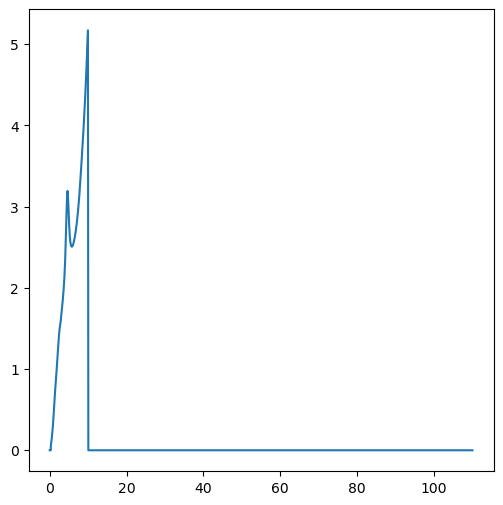

In [19]:
A_lam = red(wavelength, Av,0)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.plot(1/(wavelength)  * 1e-6/1e-10, A_lam/Av)






First, lets read in a stellar model of an A0 main sequence star. A fits file containing the model was provided with the lab ('ckm05_9500.fits'). This is a Castelli-Kurucz stellar model of an A0 main sequence star with [Fe/H]= -0.5. More information on the models can be found here: https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/ck04models/AA_README

You should see that the file contains several different columns that correspond to a difference surface gravity (log g, where g is the gravitational acceleration at the surface of the star). We want to use log(g)= 4.0, so we will want to use the "g40" column for the analysis that follows.

Plot of this model SED (flux on the y axis, wavelength on the x axis). Scale both axes logarithmically. Include axis labels and don't forget units. You can find information on units in the table header and the documentation about Castelli-Kurucz models.

(1e-24, 1e-10)

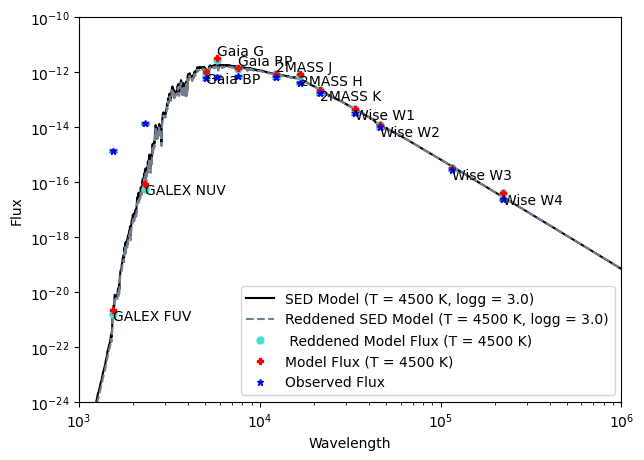

In [10]:
#UV_data = False

if UV_data == False:
    lim = 10
else:
    lim = len(mod_fluxes)

#R_star = 4.2#R_star #8#5.7621 #5.1 #5.7621
    
flux_scale = ((R_star * R_sun)/ (dist * parsec))**2 


fig, ax = plt.subplots(1, figsize = (7, 5))
#ax, ax2 = axes
#Models
#ax.plot(int_wav, int_model_flux * flux_scale, ls = '--', color = 'green')
ax.plot(wavelength, model_flux * flux_scale, color = 'black', label = 'SED Model (T = 4500 K, logg = 3.0)')

ax.plot(wavelength, model_flux * flux_scale * reddening, ls = '--', color = 'slategrey', label = 'Reddened SED Model (T = 4500 K, logg = 3.0)')
ax.errorbar(λeffs, obs_fluxes , yerr = [obs_errs[1], obs_errs[0]], 
            fmt = 'none', color = 'tab:blue', capsize=3, lw = 3)

#ax.plot(int_wav,int_model_flux, color = 'g', ls = '--')

ax.errorbar(λeffs, obs_fluxes , yerr = [obs_fluxes*0.1315, obs_fluxes*0.1315], 
            fmt = 'none', color = 'tab:blue', capsize=3, lw = 3)

ax.plot(λeffs[0:lim], mod_fluxes[0:lim] * flux_scale * red_list[0:lim], ls = 'none', marker = 'o', 
        ms = '5', color = 'turquoise', label = ' Reddened Model Flux (T = 4500 K)')

ax.plot(λeffs[0:lim], mod_fluxes[0:lim] * flux_scale, ls = 'none', marker = 'P', 
        ms = '5', color = 'red', label = 'Model Flux (T = 4500 K)')

ax.plot(λeffs, obs_fluxes, ls = 'none', marker = '*', 
        ms = '5', color = 'blue', label = 'Observed Flux')

for i in range(len(λeffs[0:lim])):
    ax.text(λeffs[i], mod_fluxes[i] * flux_scale, filter_names[i], va = ylabel_orient[i])


    
    
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()

ax.set_xlim(10**3, 10**6)
ax.set_ylim(10e-25, 10e-11)

#fig.savefig(r'SED_images\\' + star + '_reddening.png', dpi = 300)

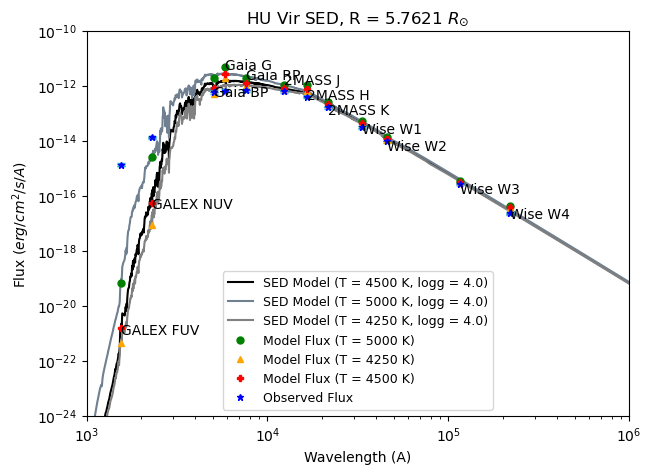

In [85]:
fig, ax = plt.subplots(1, figsize = (7, 5))

#Models
ax.set_title(f'{star} SED, R = {R_star} ' + r'$R_{\odot}$')
#ax.plot(int_wav, int_model_flux * flux_scale, ls = '--', color = 'green')
ax.plot(wavelength, model_flux * flux_scale* reddening, color = 'black', label = 'SED Model (T = 4500 K, logg = 4.0)')
ax.plot(wavelength5000, model_flux5000 * flux_scale * red5000, color = 'slategrey', label = 'SED Model (T = 5000 K, logg = 4.0)')
ax.plot(wavelength5750, model_flux5750 * flux_scale * red5750, color = 'grey', label = 'SED Model (T = 4250 K, logg = 4.0)')

ax.errorbar(λeffs, obs_fluxes , yerr = [obs_errs[1], obs_errs[0]], 
            fmt = 'none', color = 'tab:blue', capsize=3, lw = 3)

#ax.plot(int_wav,int_model_flux, color = 'g', ls = '--')

ax.errorbar(λeffs, obs_fluxes , yerr = [obs_fluxes*0.1315, obs_fluxes*0.1315], 
            fmt = 'none', color = 'tab:cyan', capsize=3, lw = 3)


ax.plot(λeffs[0:lim], mod_fluxes5000[0:lim] * flux_scale * red_list5000[0:lim], ls = 'none', marker = 'o', 
        ms = '5', color = 'green', label = 'Model Flux (T = 5000 K)')

ax.plot(λeffs[0:lim], mod_fluxes5750[0:lim] * flux_scale * red_list5750[0:lim], ls = 'none', marker = '^', 
        ms = '5', color = 'orange', label = 'Model Flux (T = 4250 K)')

ax.plot(λeffs[0:lim], mod_fluxes[0:lim] *flux_scale * red_list[0:lim], ls = 'none', marker = 'P', 
        ms = '5', color = 'red', label = 'Model Flux (T = 4500 K)')

ax.plot(λeffs[0:lim], obs_fluxes[0:lim], ls = 'none', marker = '*', 
        ms = '5', color = 'blue', label = 'Observed Flux')

for i in range(len(λeffs[0:lim])):
    ax.text(λeffs[i], mod_fluxes[i] * flux_scale, filter_names[i], va = ylabel_orient[i])

#,λeff_galexFUV
#ax.axvline(λeff_galexNUV, color = 'mediumvioletred', ls = '--')
    
    
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux $(erg/cm^{2}/s/A)$')
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend(fontsize=9)

ax.set_xlim(10**3, 10**6)
ax.set_ylim(10e-25, 10e-11)



fig.savefig(r'SED_images\\' + star + '_SED.png', dpi = 300)
#ax.set_ylim(10e-14, 10e-11)

#create synthetic observation #put error bars in
#Reddening (Leiner 2022)

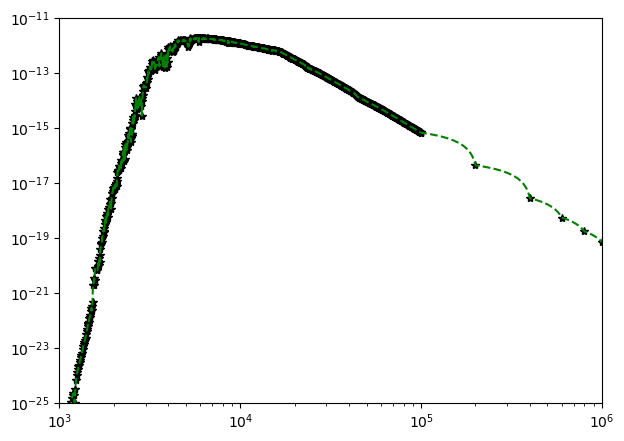

In [11]:
fig, ax = plt.subplots(1, figsize = (7, 5))

#Models

ax.plot(wavelength, model_flux * flux_scale, color = 'black', 
        ls = 'none', marker = '*', label = 'SED Model (T = 4500 K, logg = 3.0)')
ax.plot(int_wav, int_model_flux * flux_scale, ls = '--', color = 'green')

#ax.plot(λeffs, mod_fluxes * flux_scale, ls = 'none', marker = '*', 
       # ms = '5', color = 'red', label = 'Model Flux')

#for i in range(len(λeffs)):
    #ax.text(λeffs[i], mod_fluxes[i], filter_names[i], va = ylabel_orient[i])
    
#ax.plot(int_wav, int_model_flux * flux_scale, color = 'g', ls = '--')
#ax.text(λeffs[0], flux_Wise4, 'hi')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10**3, 10**6)
ax.set_ylim(10e-26, 10e-12)

plt.show()

In [ ]:
print(-2.5*np.log10(560.7463)+20.08)
print(-2.5*np.log10(131.78)+18.82)

In [ ]:
print(1/(3.0e8))

In [26]:
star_index = star_list.index(star)
vsini = float(star_data['vsini'][star_index])
period = float(star_data['VSX Period'][star_index])

print(vsini*period * 24 *3600/(2*np.pi)/(R_sun/1e3))

nan
